In [1]:
import tensorflow as tf
from tensorflow.python.client import device_lib
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    # 텐서플로가 첫 번째 GPU만 사용하도록 제한
    try:
        tf.config.set_visible_devices(gpus[0], 'GPU')
    except RuntimeError as e:
        # 프로그램 시작시에 접근 가능한 장치가 설정되어야만 합니다
        print(e)

In [2]:
import os
from tensorflow.keras import models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras import optimizers
from tensorflow.keras.applications.mobilenet import MobileNet

import numpy as np
import matplotlib.pyplot as plt
import os

In [3]:
pwd

'e:\\Pill Project\\code\\Model'

In [4]:
# 데이터셋 디렉터리 경로
dataset_dir = 'E:\\Pill Project\\half_data'
train_dir = os.path.join(dataset_dir, 'train')
validation_dir = os.path.join(dataset_dir, 'valid')
# test_dir = os.path.join(dataset_dir, 'test')

# 사진 크기
image_width = 224
image_height = 224

# ImageDataGenerator 초기화
# 0~1 사이로 숫자값 변경
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)
# test_datagen = ImageDataGenerator(rescale=1./255)

# 훈련셋 제너레이터
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(image_width, image_height),
    batch_size=64,
    class_mode='categorical')

# 검증셋 제너레이터
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(image_width, image_height),
    batch_size=64,
    class_mode='categorical')

# # 테스트셋 제너레이터
# test_generator = test_datagen.flow_from_directory(
#     test_dir,
#     target_size=(image_width, image_height),
#     batch_size=64,
#     class_mode='categorical')

Found 207360 images belonging to 400 classes.
Found 51840 images belonging to 400 classes.


In [5]:
# 훈련셋에서 배치를 생성
for data_batch, labels_batch in train_generator:
    break

In [6]:
# 데이터 배치의 크기
# (배치개수, 이미지너비, 이미지높이, RGB채널)
data_batch.shape

(64, 224, 224, 3)

In [7]:
# 라벨 배치의 크기
# (배치개수, 카테고리개수)
labels_batch.shape

(64, 400)

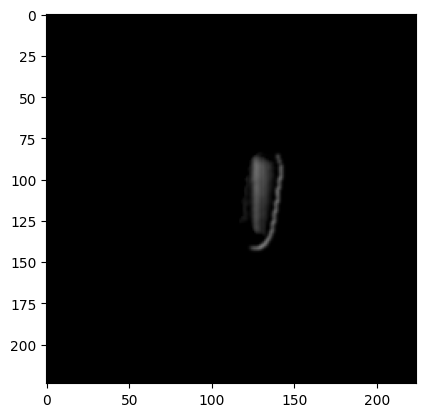

In [8]:
# 첫 번째 이미지 출력
image = data_batch[0]

plt.imshow(image)
plt.show()

# 기존 모델

In [9]:
# 사전 훈련된 MobileNet 모델 로드
base_model = MobileNet(include_top=False,
                       alpha=1.0,
                       weights='imagenet',  # ImageNet으로 사전 훈련된 가중치 사용
                       input_shape=(224, 224, 3))

# 모델의 모든 층을 학습 가능하게 설정 (선택적)
for layer in base_model.layers:
    layer.trainable = True


In [10]:
# 새로운 모델 구성
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dense(400, activation='softmax')  # 400개의 클래스에 대한 출력 레이어
])

In [11]:
# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Function (None, 7, 7, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               262400    
_________________________________________________________________
dense_1 (Dense)              (None, 400)               102800    
Total params: 3,594,064
Trainable params: 3,572,176
Non-trainable params: 21,888
_________________________________________________________________


In [13]:
import time

# 모델 학습을 위한 설정
epochs = 120  # 여기서 원하는 에폭 수로 설정하세요.

start_time = time.time()

# 모델 학습
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size
)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"The model was trained in: {elapsed_time:.2f} seconds")


Epoch 1/120
3240/3240 [==============================] - 2324s 714ms/step - loss: 1.9829 - accuracy: 0.5159 - val_loss: 0.9593 - val_accuracy: 0.7100
Epoch 2/120
3240/3240 [==============================] - 913s 282ms/step - loss: 0.5607 - accuracy: 0.8254 - val_loss: 0.4884 - val_accuracy: 0.8441
Epoch 3/120
3240/3240 [==============================] - 791s 244ms/step - loss: 0.3639 - accuracy: 0.8816 - val_loss: 0.4806 - val_accuracy: 0.8444
Epoch 4/120
3240/3240 [==============================] - 892s 275ms/step - loss: 0.2750 - accuracy: 0.9083 - val_loss: 0.4518 - val_accuracy: 0.8484
Epoch 5/120
3240/3240 [==============================] - 930s 287ms/step - loss: 0.2201 - accuracy: 0.9261 - val_loss: 0.3699 - val_accuracy: 0.8744
Epoch 6/120
3240/3240 [==============================] - 858s 265ms/step - loss: 0.1839 - accuracy: 0.9377 - val_loss: 0.4274 - val_accuracy: 0.8589
Epoch 7/120
3240/3240 [==============================] - 943s 291ms/step - loss: 0.1571 - accuracy: 0.946

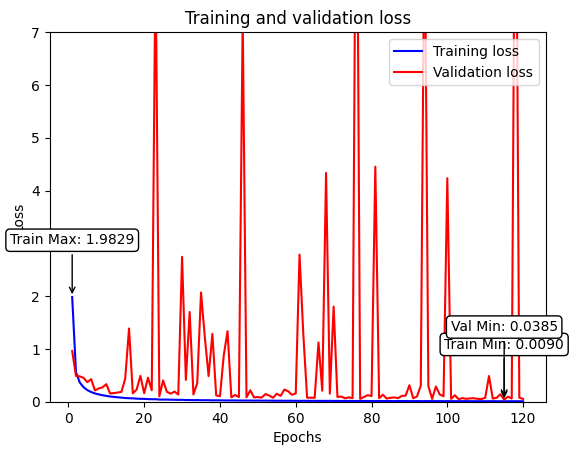

In [14]:
loss = history.history['loss'] # training loss
val_loss = history.history['val_loss'] # validation loss

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Add maximum and minimum values for training loss
max_loss = max(loss)
min_loss = min(loss)
max_loss_epoch = loss.index(max_loss) + 1
min_loss_epoch = loss.index(min_loss) + 1

plt.annotate(f'Train Max: {max_loss:.4f}', xy=(max_loss_epoch, max_loss), xytext=(max_loss_epoch, max_loss+1),
             arrowprops=dict(facecolor='black', arrowstyle='->'), bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'), horizontalalignment='center')
plt.annotate(f'Train Min: {min_loss:.4f}', xy=(min_loss_epoch, min_loss), xytext=(min_loss_epoch, min_loss+1),
             arrowprops=dict(facecolor='black', arrowstyle='->'), bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'), horizontalalignment='center')

# Add maximum and minimum values for validation loss
max_val_loss = max(val_loss)
min_val_loss = min(val_loss)    
max_val_loss_epoch = val_loss.index(max_val_loss) + 1
min_val_loss_epoch = val_loss.index(min_val_loss) + 1

plt.annotate(f'Val Max: {max_val_loss:.4f}', xy=(max_val_loss_epoch, max_val_loss), xytext=(max_val_loss_epoch+2, max_val_loss+1),
             arrowprops=dict(facecolor='black', arrowstyle='->'), bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'), horizontalalignment='center')
plt.annotate(f'Val Min: {min_val_loss:.4f}', xy=(min_val_loss_epoch, min_val_loss), xytext=(min_val_loss_epoch, min_val_loss+1.3),
             arrowprops=dict(facecolor='black', arrowstyle='->'), bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'), horizontalalignment='center')

plt.ylim(0, 7)  # Set the y-axis limits between 0 and 1

plt.show()



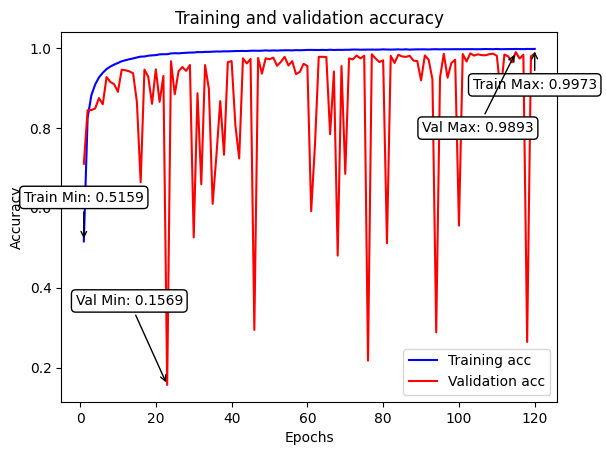

In [15]:
acc = history.history['accuracy'] # training accuracy
val_acc = history.history['val_accuracy'] # validation accuracy

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Add maximum and minimum values for training accuracy
max_acc = max(acc)
min_acc = min(acc)
max_acc_epoch = acc.index(max_acc) + 1
min_acc_epoch = acc.index(min_acc) + 1

plt.annotate(f'Train Max: {max_acc:.4f}', xy=(max_acc_epoch, max_acc), xytext=(max_acc_epoch, max_acc-0.1),
             arrowprops=dict(facecolor='black', arrowstyle='->'), bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'), horizontalalignment='center')
plt.annotate(f'Train Min: {min_acc:.4f}', xy=(min_acc_epoch, min_acc), xytext=(min_acc_epoch, min_acc+0.1),
             arrowprops=dict(facecolor='black', arrowstyle='->'), bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'), horizontalalignment='center')

# Add maximum and minimum values for validation accuracy
max_val_acc = max(val_acc)
min_val_acc = min(val_acc)
max_val_acc_epoch = val_acc.index(max_val_acc) + 1
min_val_acc_epoch = val_acc.index(min_val_acc) + 1

plt.annotate(f'Val Max: {max_val_acc:.4f}', xy=(max_val_acc_epoch, max_val_acc), xytext=(max_val_acc_epoch-10, max_val_acc-0.2),
             arrowprops=dict(facecolor='black', arrowstyle='->'), bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'), horizontalalignment='center')
plt.annotate(f'Val Min: {min_val_acc:.4f}', xy=(min_val_acc_epoch, min_val_acc), xytext=(min_val_acc_epoch-10, min_val_acc+0.2),
             arrowprops=dict(facecolor='black', arrowstyle='->'), bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'), horizontalalignment='center')

plt.show()


In [16]:
# 모델 저장
# model.save('E:\Pill Project\model/AlexNet_10_31_data18_batch16_epoch30_m2.h5')

SAVED_MODEL_PATH = 'E:\Pill Project\model_h5/MobileNet_11_10_data400_batch32_epoch120_m1_pre.h5'
export_path = os.path.join(SAVED_MODEL_PATH)

tf.keras.models.save_model(
  model,
  export_path,
  overwrite=True,
  include_optimizer=True,
  save_format=None,
  signatures=None,
  options=None
)
print('\nSaved model:')


Saved model:


In [ ]:
# 저장된 모델 파일 로드
model = models.load_model('c:/Users/LEE/Desktop/app/assets/AlexNet_10_31_data18_batch16_epoch30_m1.tflite')

In [ ]:
# 테스트셋 평가
results = model.evaluate(test_generator)
results

405/405 [==============================] - 105s 258ms/step - loss: 0.3269 - accuracy: 0.9201


[0.3269144296646118, 0.9200617074966431]

In [ ]:
# 테스트셋 예측
results = model.predict(test_generator)
results


array([[0.0000000e+00, 6.7517599e-34, 0.0000000e+00, ..., 0.0000000e+00,
        5.4453811e-36, 6.4441246e-26],
       [4.7104237e-30, 2.4400703e-26, 3.8407118e-29, ..., 1.4998909e-21,
        1.2567253e-27, 1.2149968e-20],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 1.7676101e-31],
       ...,
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 5.4061440e-34, 0.0000000e+00, ..., 0.0000000e+00,
        1.3848214e-26, 2.4400465e-38],
       [2.7035816e-23, 1.8130349e-10, 1.7338660e-20, ..., 9.5538569e-30,
        6.7365394e-28, 1.1803977e-27]], dtype=float32)

In [ ]:
# 예측값을 인덱스로 변환
results = np.argmax(results, 1)
results

array([386, 280, 194, ...,  98, 102, 117], dtype=int64)

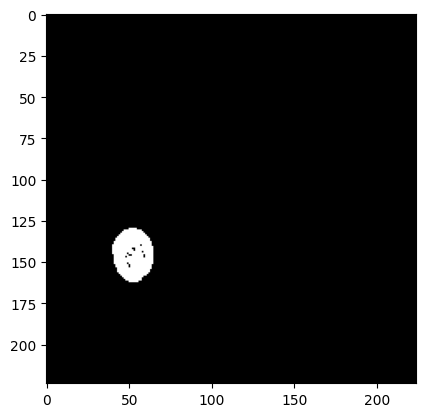

In [ ]:
# 테스트셋에서 배치를 생성
for data_batch, labels_batch in test_generator:
    break
    
# 테스트셋의 첫 번째 이미지 출력
image = data_batch[0]

plt.imshow(image)
plt.show()


In [ ]:
# 테스트셋 배치 데이터를 예측
results = model.predict(data_batch)

# 테스트셋의 첫 번째 라벨 이름 출력
labels_list[np.argmax(results[0])]


NameError: name 'labels_list' is not defined